# Install SLEAP
Don't forget to set **Runtime** -> **Change runtime type...** -> **GPU** as the accelerator.

In [ ]:
!pip -q install sleap==1.1.0

     |████████████████████████████████| 52.8MB 63kB/s 
     |████████████████████████████████| 1.4MB 50.8MB/s 
     |████████████████████████████████| 829kB 50.1MB/s 
     |████████████████████████████████| 235kB 56.9MB/s 
     |████████████████████████████████| 184kB 58.9MB/s 
     |████████████████████████████████| 21.6MB 1.3MB/s 
     |████████████████████████████████| 320.4MB 53kB/s 
     |████████████████████████████████| 911kB 53.8MB/s 
     |████████████████████████████████| 194kB 60.3MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 20.1MB 1.5MB/s 
     |████████████████████████████████| 165.5MB 95kB/s 
     |████████████████████████████████| 2.3MB 46.7MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 460kB 52.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 849kB 54.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.

In [ ]:
import sleap
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import operator
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sleap.versions()

SLEAP: 1.1.0
TensorFlow: 2.3.1
Numpy: 1.19.5
Python: 3.7.10
OS: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic


# Download training data

In [ ]:
!curl -L --output labels.slp https://www.dropbox.com/s/b990gxjt3d3j3jh/210205.sleap_wt_gold.13pt.pkg.slp?dl=1
!ls -lah

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  773M  100  773M    0     0  81.8M      0  0:00:09  0:00:09 --:--:-- 63.9M
total 774M
drwxr-xr-x 1 root root 4.0K Apr 30 18:31 .
drwxr-xr-x 1 root root 4.0K Apr 30 18:28 ..
drwxr-xr-x 4 root root 4.0K Apr 21 13:38 .config
-rw-r--r-- 1 root root 774M Apr 30 18:31 labels.slp
drwxr-xr-x 1 root root 4.0K Apr 21 13:39 sample_data


# Load the training data

In [ ]:
# SLEAP Labels files (.slp) can include the images as well as labeled instances and
# other metadata for a project.
 #[frames][instances=frames with labels]
labels = sleap.load_file("labels.slp")
labels.describe()


Skeleton: Skeleton(nodes=[head, thorax, abdomen, wingL, wingR, forelegL4, forelegR4, midlegL4, midlegR4, hindlegL4, hindlegR4, eyeL, eyeR], edges=[thorax->head, thorax->abdomen, thorax->wingL, thorax->wingR, thorax->forelegL4, thorax->forelegR4, thorax->midlegL4, thorax->midlegR4, thorax->hindlegL4, thorax->hindlegR4, head->eyeL, head->eyeR], symmetries=[forelegL4<->forelegR4, hindlegL4<->hindlegR4, wingL<->wingR, eyeL<->eyeR, midlegL4<->midlegR4])
Videos: ['labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp']
Frames (user/predicted): 2,000/0
Instances (user/predicted): 4,000/0
Tracks: [Track(spawned_on=0, name='female'), Trac

In [ ]:
# Labels are list-like containers whose elements are LabeledFrames
labels = labels.with_user_labels_only()

labeled_frame = labels[0]
# Let us divide the labels dataset into 3, 80% on a labels_train, 20% on labels_val_test
labels_train, labels_val_test = train_test_split(labels.with_user_labels_only(), train_size=0.8, test_size=0.2)

# And divide further on, 10% on labels_val and the other 10% on labels_test
labels_val, labels_test = train_test_split(labels_val_test, train_size=0.5, test_size=0.5)

print(f"Number of labels: {len(labels)}")
print("Train: ", len(labels_train))
print("Validation: ", len(labels_val))
print("Test: ", len(labels_test))

print("Compare that each list contains LabeledFrames")
print("Train->", type(labels_train[0]),", Validation->", type(labels_val[0]), ", Testing->", labels_test[0])

labeled_frame

Number of labels: 2000
Train:  1600
Validation:  200
Test:  200
Compare that each list contains LabeledFrames
Train-> <class 'sleap.instance.LabeledFrame'> , Validation-> <class 'sleap.instance.LabeledFrame'> , Testing-> LabeledFrame(video=HDF5Video('labels.slp'), frame_idx=10800, instances=2)


LabeledFrame(video=HDF5Video('labels.slp'), frame_idx=7455, instances=2)

In [ ]:
# LabeledFrames are containers for instances that were labeled in a single frame
instance = labeled_frame[0]
instance


Instance(video=Video(filename=labels.slp, shape=(55, 1024, 1024, 1), backend=HDF5Video), frame_idx=7455, points=[head: (633.5, 806.0), thorax: (589.2, 807.0), abdomen: (557.2, 813.5), wingL: (538.7, 812.6), wingR: (538.9, 814.8), forelegL4: (652.0, 797.0), forelegR4: (655.2, 814.1), midlegL4: (611.5, 779.4), midlegR4: (614.1, 862.1), hindlegL4: (540.4, 778.7), hindlegR4: (570.8, 843.3), eyeL: (621.4, 795.1), eyeR: (622.4, 816.8)], track=Track(spawned_on=0, name='female'))

In [ ]:
# They can be converted to numpy arrays where each row corresponds to the coordinates
# of a different body part:
pts = instance.numpy()
pts

rec.array([[633.53948229, 806.03863528],
           [589.19035306, 807.03863528],
           [557.15087078, 813.50056467],
           [538.69299954, 812.58872353],
           [538.94660133, 814.78180105],
           [652.00028234, 797.03863528],
           [655.24461549, 814.09569239],
           [611.5       , 779.38494116],
           [614.08309628, 862.14672415],
           [540.41406264, 778.65699169],
           [570.76953595, 843.28358376],
           [621.39804036, 795.0546654 ],
           [622.35635663, 816.77982951]],
          dtype=float64)

# Setup training data generation

For a top-down pipeline, the subnetwork (*centered instance model*) that takes cropped images as input and produces pose estimates as output requires **confidence maps** to train against as targets.

Here we will create a pipeline that does the sampling, augmentation, data generation and
batching so we can create our input/output pairs.

## Helper functions
 One to set to Sleap Label Class (the list-like containers),
 the other to get the pipeline and centered-instance models.

In [ ]:
# First convert to sleap.io.dataset.Labels class our training list
def toSleapLabelClass(dataset):
  return sleap.io.dataset.Labels(dataset)

# Then set to pipeline, and add transformations for the centered-instance model.
def pipeline(dataset):
  asSleapLabel = toSleapLabelClass(dataset)
  pipe = asSleapLabel.with_user_labels_only().to_pipeline()
  pipe += sleap.pipelines.ImgaugAugmenter.from_config(sleap.pipelines.AugmentationConfig(rotate=True, rotation_min_angle=-180, rotation_max_angle=180))
  pipe += sleap.pipelines.Normalizer()
  pipe += sleap.pipelines.InstanceCentroidFinder(center_on_anchor_part=True, anchor_part_names="thorax", skeletons=labels.skeletons)
  pipe += sleap.pipelines.InstanceCropper(crop_width=160, crop_height=160)
  pipe += sleap.pipelines.InstanceConfidenceMapGenerator(sigma=1.5, output_stride=2)
  pipe += sleap.pipelines.Batcher(batch_size=4, drop_remainder=True)
  return pipe

# Pipelining for each dataset
p_train = pipeline(labels_train)
p_val = pipeline(labels_val)
p_test = pipeline(labels_test)

# This pipeline will output dictionaries with tensors containing frame data:
p_train.describe()

          instance_image: type=EagerTensor, shape=(4, 160, 160, 1), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
                    bbox: type=EagerTensor, shape=(4, 4), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
         center_instance: type=EagerTensor, shape=(4, 13, 2), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
     center_instance_ind: type=EagerTensor, shape=(4, 1), dtype=tf.int32, device=/job:localhost/replica:0/task:0/device:CPU:0
           all_instances: type=EagerTensor, shape=(4, 2, 13, 2), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
                centroid: type=EagerTensor, shape=(4, 2), dtype=tf.float32, device=/job:localhost/replica:0/task:0/device:CPU:0
       full_image_height: type=EagerTensor, shape=(4, 1), dtype=tf.int32, device=/job:localhost/replica:0/task:0/device:CPU:0
        full_image_width: type=EagerTensor, shape=(4, 1), dtype=tf.int32, device=/job:l

Training
<class 'dict'>
dict_keys(['instance_image', 'bbox', 'center_instance', 'center_instance_ind', 'all_instances', 'centroid', 'full_image_height', 'full_image_width', 'raw_image_size', 'example_ind', 'video_ind', 'frame_ind', 'scale', 'skeleton_inds', 'instance_confidence_maps'])
(4, 80, 80, 13)
(4, 160, 160, 1)
(4, 4)
(4, 13, 2)
(4, 1)
(4, 2, 13, 2)
(4, 2)
(4, 1)
(4, 1)
(4, 3)
(4, 1)
(4, 1)
(4, 1)
(4, 2)
(4, 2)
(4, 80, 80, 13)
Validation
<class 'dict'>
dict_keys(['instance_image', 'bbox', 'center_instance', 'center_instance_ind', 'all_instances', 'centroid', 'full_image_height', 'full_image_width', 'raw_image_size', 'example_ind', 'video_ind', 'frame_ind', 'scale', 'skeleton_inds', 'instance_confidence_maps'])
(4, 80, 80, 13)
Test
<class 'dict'>
dict_keys(['instance_image', 'bbox', 'center_instance', 'center_instance_ind', 'all_instances', 'centroid', 'full_image_height', 'full_image_width', 'raw_image_size', 'example_ind', 'video_ind', 'frame_ind', 'scale', 'skeleton_inds', 'in

Text(0.5, 1.0, 'TEST:Confidence maps (output)')

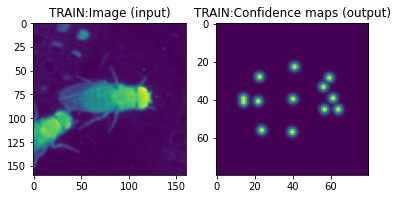

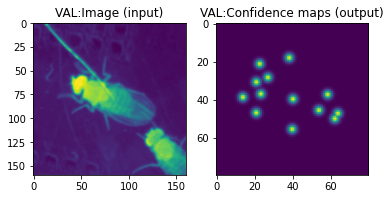

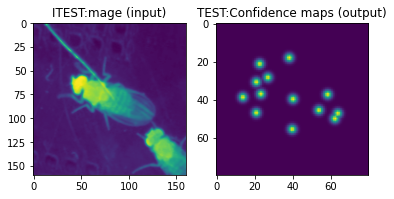

In [ ]:
# We can generate an example from the pipeline to play around with the data:
print("Training")
ex = p_train.peek()
print(type(ex))
print(ex.keys())
print(ex["instance_confidence_maps"].shape)

i = 0
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ex["instance_image"][i].numpy().squeeze())
plt.title("TRAIN:Image (input)")
plt.subplot(1,2,2)
plt.imshow(ex["instance_confidence_maps"][i].numpy().max(axis=-1))
plt.title("TRAIN:Confidence maps (output)")

# We can generate an example from the pipeline to play around with the data:
print("Validation")
ex_val = p_val.peek()
print(type(ex_val))
print(ex_val.keys())
print(ex_val["instance_confidence_maps"].shape)

i = 0
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ex_val["instance_image"][i].numpy().squeeze())
plt.title("VAL:Image (input)")
plt.subplot(1,2,2)
plt.imshow(ex_val["instance_confidence_maps"][i].numpy().max(axis=-1))
plt.title("VAL:Confidence maps (output)")

# We can generate an example from the pipeline to play around with the data:
print("Test")
ex_test = p_test.peek()
print(type(ex_val))
print(ex_val.keys())
print(ex_val["instance_confidence_maps"].shape)

i = 0
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ex_val["instance_image"][i].numpy().squeeze())
plt.title("ITEST:mage (input)")
plt.subplot(1,2,2)
plt.imshow(ex_val["instance_confidence_maps"][i].numpy().max(axis=-1))
plt.title("TEST:Confidence maps (output)")

# Setting up a neural network model

Here we'll create a simple UNet CNN that is compatible with the input and output shapes
that we're generating.

In [ ]:
# Instantiate the backbone builder.
unet = sleap.nn.architectures.unet.UNet(filters=32, filters_rate=1.5, down_blocks=4, up_blocks=3, up_interpolate=True)

# Create the input layer (see above for the dimensions)
x_in = tf.keras.layers.Input((160, 160, 1))

# Create the feature extractor backbone.
x_features, x_intermediate = unet.make_backbone(x_in)

# Do a 1x1 conv with linear activation to remap activations to the number of channels in
# the confidence maps (see above)
x_confmaps = tf.keras.layers.Conv2D(filters=13, kernel_size=1, strides=1, padding="same")(x_features)

# Create a Model that links the whole graph
model = tf.keras.Model(x_in, x_confmaps)
model.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
stack0_enc0_conv0 (Conv2D)      (None, 160, 160, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
stack0_enc0_act0_relu (Activati (None, 160, 160, 32) 0           stack0_enc0_conv0[0][0]          
__________________________________________________________________________________________________
stack0_enc0_conv1 (Conv2D)      (None, 160, 160, 32) 9248        stack0_enc0_act0_relu[0][0]      
_______________________________________________________________________________________

# Train the model

Now we have everything we need to do basic training!

Let's set up a custom training loop that trains on each batch of data from our pipeline.

See [this guide](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) for more info on how to customize the training process in TensorFlow.

In [ ]:
# Setup the optimizer and loss function.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.MeanSquaredError()

# Define a "training step" function. This does the forward/backward passes and applies
# the gradients to update the model weights.
@tf.function
def train_step(ex):
    with tf.GradientTape() as tape:
        predicted_confmaps = model(ex["instance_image"])
        loss_value = loss_fn(ex["instance_confidence_maps"], predicted_confmaps)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value

# Training loop, go!
epochs = 3
loss_val = []
for epoch in range(epochs):
    for step, ex in enumerate(p_train.make_dataset()):
        loss_val = train_step(ex)
        if step % 100 == 0:
            print(f"Epoch {epoch:03d} | Step {step:03d} | loss = {loss_val:.5f}")

Epoch 000 | Step 000 | loss = 0.00116
Epoch 000 | Step 100 | loss = 0.00103
Epoch 000 | Step 200 | loss = 0.00105
Epoch 000 | Step 300 | loss = 0.00101
Epoch 000 | Step 400 | loss = 0.00095
Epoch 000 | Step 500 | loss = 0.00093
Epoch 000 | Step 600 | loss = 0.00093
Epoch 000 | Step 700 | loss = 0.00085
Epoch 001 | Step 000 | loss = 0.00082
Epoch 001 | Step 100 | loss = 0.00080
Epoch 001 | Step 200 | loss = 0.00074
Epoch 001 | Step 300 | loss = 0.00072
Epoch 001 | Step 400 | loss = 0.00057
Epoch 001 | Step 500 | loss = 0.00068
Epoch 001 | Step 600 | loss = 0.00059
Epoch 001 | Step 700 | loss = 0.00059
Epoch 002 | Step 000 | loss = 0.00052
Epoch 002 | Step 100 | loss = 0.00064
Epoch 002 | Step 200 | loss = 0.00050
Epoch 002 | Step 300 | loss = 0.00054
Epoch 002 | Step 400 | loss = 0.00039
Epoch 002 | Step 500 | loss = 0.00055
Epoch 002 | Step 600 | loss = 0.00045
Epoch 002 | Step 700 | loss = 0.00046


In [ ]:
model.compile(optimizer,loss_fn)
print(np.mean(loss_val))

0.00055482035


Cool! We did some training -- let's visualize how well the model is doing so far:

### Helper Functions
Here we set some functions to get the average RMSE (root mean squared error) and another function to get (x,y) coordinates of the generated heatmaps.

In [ ]:
# Get RMSE of GT and Prediction
def get_rmse(ground_truth, prediction):
  return mean_squared_error(ground_truth, prediction, squared=False)

def avg_rmse(list_of_GT_indx, list_of_Pred_indx):
  rmse_list = list()

  for gt, pred in zip(list_of_GT_indx, list_of_Pred_indx):
    for gtXY, predXY in zip(gt, pred):
      rmse_list.append(get_rmse(gtXY, predXY))
    
  return sum(rmse_list)/len(rmse_list)

# Get Indexes for independent batches
def getIdx(maps):
  #Get sizes for batches and heatmaps
  sizeOfBatch = maps.shape[0]
  sizeOfHeatMaps = maps.shape[3]

  #Get indexes for each individual heatmap
  list_of_indx = list()
  for i in range(0,sizeOfBatch):
    listIdx = list()
    for j in range (0,sizeOfHeatMaps):
      listIdx.append(np.unravel_index(maps[i,:,:,j].numpy().argmax(), maps[i,:,:,j].numpy().shape))
    list_of_indx.append(listIdx)
  # list_of_indx is a list of list that contains the coordinates for each batch [[(x01,y01),(x02,y02)..(x0j,y0j)],..,[(xi1,yi1)..(xij,yij)]]
  return list_of_indx


In [ ]:
ex = p_train.peek()
predicted_confmaps = model(ex["instance_image"])
ground_truth = ex["instance_confidence_maps"]

#print(p_train.shape())
list_Pred_Idx = getIdx(predicted_confmaps)
list_GT_Idx = getIdx(ground_truth)

ex_val = p_val.peek()
pred_conf_val = model(ex_val["instance_image"], training=False)
ground_truth_val = ex_val["instance_confidence_maps"]

list_Pred_Idx_val = getIdx(predicted_confmaps)
list_GT_Idx_val = getIdx(ground_truth)
# RMSE
print("Average RMSE: ", avg_rmse(list_GT_Idx, list_Pred_Idx))

Average RMSE:  1.274963375044412


# Let us do some plotting on the training set
With the helper functions above we can plot
on our trained set and compare the instance ground truth
and predicted confidence maps.

In [ ]:
# Plotting Predicted and GT
fig, (ax1,ax2) = plt.subplots(1,2)
for batch_pred, batch_gt in zip(list_Pred_Idx,list_GT_Idx):
  for maps_pred, maps_gt in zip(batch_pred,batch_gt):
      xPred, yPred = zip(maps_pred)
      ax1.scatter(xPred, yPred, c="green")
      ax1.set_title("Predicted Confmaps")
      xGT, yGT = zip(maps_gt)
      ax2.scatter(xGT, yGT, c="red")
      ax2.set_title("Ground Truth")

NameError: ignored

### Organinzing Data
Before we do evaluation and testing, let's organize the data that we are going to evaluate and test.

In [ ]:
### First training


# Evaluation
Evaluate the trained set with the test and validation set

In [ ]:
def test_step(x, y):
  val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
  val_logits = model(x, training=False)
  val_acc_metric.update_state(y, val_logits)

In [ ]:
import time

### EVALUATION
def evaluation(training_dataset,validation_dataset):
  
  # Preprocess the datasets:
  p_train = pipeline(training_dataset)
  p_val = pipeline(validation_dataset)

  


  return np.mean(loss_val), np.mean(rmse)

### TESTING
def testing(training_dataset, testing_dataset):
  # Preprocess the datasets:
  p_train = pipeline(training_dataset)
  p_test = pipeline(testing_dataset)

  ex_train = p_train.peek()
  ex_test = p_test.peek()  

  predicted_confmaps_train = model(ex_train["instance_image"])
  ground_truth_train = ex_train["instance_confidence_maps"]
  
  predicted_confmaps_test = model(ex_test["instance_image"])
  ground_truth_test = ex_test["instance_confidence_maps"]

  list_Pred_Idx_train = getIdx(predicted_confmaps_train)
  list_GT_Idx_train = getIdx(ground_truth_train)
  
  list_Pred_Idx_test = getIdx(predicted_confmaps_test)
  list_GT_Idx_test = getIdx(ground_truth_test)

  rmse = [avg_rmse(list_Pred_Idx_train, list_GT_Idx_train), avg_rmse(list_Pred_Idx_test, list_GT_Idx_test)]
  return np.mean(loss_val), np.mean(rmse)


In [ ]:
dataset = [labels_train, labels_val, labels_test]

#evaluation(dataset,'validation_dataset')
testing(labels_train, labels_test)

(0.0004805837, 3.258192526749203)

In [ ]:
# Get model
inputs = tf.keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
# Instantiate an optimizer to train the model.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(labels_train)
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(labels_val)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

#result(train_acc_metric)

NameError: ignored

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[val_acc_metric,train_acc_metric],
)

In [ ]:
import sys
sys.setrecursionlimit(1000000)
print("Fit model on training data")
history = model.fit(
    labels_train,
    labels_val,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(val_acc_metric,train_acc_metric),
)

Fit model on training data


NameError: ignored

Not so great huh? Train a while longer and see how we do then.

In [ ]:
epochs = 20
for epoch in range(epochs):
    for step, ex in enumerate(p.make_dataset()):
        loss_val = train_step(ex)
        if step % 100 == 0:
            print(f"Epoch {epoch:03d} | Step {step:03d} | loss = {loss_val:.5f}")

NameError: ignored

In [ ]:
ex = p.peek()
print(type(ex))
print(ex.keys())
print(ex["instance_confidence_maps"].shape)

predicted_confmaps = model(ex["instance_confidence_maps"])

i = 0
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(ex["instance_image"][i].numpy().squeeze())
plt.title("Image (input)")
plt.subplot(1,3,2)
plt.imshow(ex["instance_confidence_maps"][i].numpy().max(axis=-1))
plt.title("True confidence maps (output)")
plt.subplot(1,3,3)
plt.imshow(predicted_confmaps[i].numpy().max(axis=-1))
plt.title("Predicted confidence maps (output)")

<class 'dict'>
dict_keys(['instance_image', 'bbox', 'center_instance', 'center_instance_ind', 'all_instances', 'centroid', 'full_image_height', 'full_image_width', 'raw_image_size', 'example_ind', 'video_ind', 'frame_ind', 'scale', 'skeleton_inds', 'instance_confidence_maps'])
(4, 80, 80, 13)


NotFoundError: ignored